## 202211866 최대승
* Cifar-10 데이터를 사용하여 GAN 실습을 진행했습니다.
* 층을 깊게 설정하고 싶어서 인코더 과정과 디코더 과정에 각각 층을 더 추가하였습니다.

In [2]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [4]:
import pickle
import torch
import numpy as np

# CIFAR-10 데이터 로드 함수
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        # 레이블은 필요 없으므로 제외
        images = images.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    return images

# 전체 CIFAR-10 데이터셋 로드 함수 (레이블과 테스트 제외)
def load_dataset():
    path_prefix = '/gdrive/MyDrive/ML/cifar-10-batches-py/'  # CIFAR-10 파일이 위치한 Google Drive 경로
    train_X = []

    # data_batch_1 ~ data_batch_5 로드하여 훈련 데이터로 사용
    for i in range(1, 6):
        batch_file = path_prefix + f'data_batch_{i}'
        images = load_cifar_batch(batch_file)
        train_X.append(images)

    # 리스트 데이터를 하나의 numpy 배열로 변환
    train_X = np.vstack(train_X)

    # 텐서로 변환
    train_X = torch.tensor(train_X, dtype=torch.float)

    return train_X

# 데이터 사이즈 체크용
A =  load_dataset()
print(A.size())

torch.Size([50000, 3, 32, 32])


In [5]:
def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2 # 하이퍼 탄젠트의 결과인 -1부터 1사이의 결과를 흑백 바이너리 결과인 1또는 0으로 바꾸려고
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [17]:
################################
#      Discriminator 설계      # 32*32 사이즈의 인풋 데이터를 0과 1로 분류해냄
################################

class cifar10_Discriminator(nn.Module):

  def __init__(self, config):
    super(cifar10_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"]
    # 은닉층 노드 수
    self.hnode1 = config["d_hidden_node1"]
    self.hnode2 = config["d_hidden_node2"]
    self.hnode3 = config["d_hidden_node3"]
    self.hnode4 = config["d_hidden_node4"]


    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["d_output_node"] # 0과 1

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode1, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            #  nn.Linear(self.hnode1, self.hnode1, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),

                             nn.Linear(self.hnode1, self.hnode2, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                             nn.Linear(self.hnode2, self.hnode3, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            #  nn.Linear(self.hnode1, self.hnode4, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),


                             nn.Linear(self.hnode3, self.hnode4, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            #  nn.Linear(self.hnode4, self.hnode4, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),

                             nn.Linear(self.hnode4, self.onode, bias=True),
                             nn.Sigmoid())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis





################################
#        Generator 설계        # # GAN의 목적은 Generator를 잘 학습시키는 것이다. Discriminator이 아니라.
################################

class cifar10_Generator(nn.Module):

  def __init__(self, config):
    super(cifar10_Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["g_input_node"]
    # 은닉층 노드 수
    self.hnode1 = config["g_hidden_node1"]

    self.hnode2 = config["g_hidden_node2"]

    self.hnode3 = config["g_hidden_node3"]

    self.hnode4 = config["g_hidden_node4"]

    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["g_output_node"]

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode1, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),


                            #  nn.Linear(self.hnode1, self.hnode1, bias=True),
                            # #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),

                             nn.Linear(self.hnode1, self.hnode2, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            # nn.Linear(self.hnode2, self.hnode2, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),

                             nn.Linear(self.hnode2, self.hnode3, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            #  nn.Linear(self.hnode3, self.hnode3, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),


                             nn.Linear(self.hnode3, self.hnode4, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),

                            #  nn.Linear(self.hnode4, self.hnode4, bias=True),
                            #  nn.LeakyReLU(),
                            #  nn.Dropout(0.1),

                             nn.Linear(self.hnode4, self.onode, bias=True),
                             nn.Tanh())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

In [7]:
def get_noise(batch_size=16, g_input_node=100):
    return torch.randn(batch_size, g_input_node)

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda()
    hypothesis = model(X)
    print(hypothesis.size())
    hypothesis_ = hypothesis.reshape((-1,3,32,32))
    print(hypothesis_.size())
    imshow_grid(hypothesis_)

## 코드 최종본

In [15]:
# 모델 학습 함수
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = cifar10_Discriminator(config).cuda()
  G = cifar10_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset()
  print(input_features.size()) #  참고로 torch.Size([50000, 3, 32, 32])

  # DataLoader를 통해 50000개의 데이터를 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  # 3*32*32인 데이터 100개씩으로 쪼개짐.
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])

  # D의 결과를 위한 바이너리 크로스엔트로피 비용 함수
  loss_func = nn.BCELoss()

  # Discriminator와 Generator 옵티마이저 함수 지정
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr=config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr=config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    D.train()
    G.train()

    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []

    for (step, batch) in enumerate(train_dataloader): # 각 배치는 '3*32*32인 데이터 100개'
      #print(f"batch: {batch.size()}")

      input_features = batch

      # 배치가 원래는 (100, 3, 32, 32)지만, 즉, (100,3072)이지만, 첫번째 노드층에 입력해주기 위해서 (3072, 첫번째 노드층 개수)로 변경시켜줌.
      input_features = input_features.view(-1,config['d_input_node']).cuda()  # 배치 크기는 그대로 두고 나머지 차원들을 하나로 합침




      ################################
      #      Discriminator 학습      #
      ################################

      # 역전파 변화도 초기화
      D_optimizer.zero_grad()

      # 진짜 데이터의 순전파(예측) 결과 (0 아니면 1)와 진짜 데이터의 레이블인 1 사이의 로스값 계산
      real_hypothesis = D(input_features) # 순전파 결과
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda() # 진짜 데이터의 레이블로써 torch.ones를 (배치사이즈,1) 크기로 만들어냄.
      real_cost = loss_func(real_hypothesis, real_labels) # 정답 이미지를 1로 레이블링하고서 로스값 계산

      # 가짜 데이터의 순전파(예측) 결과 (0 아니면 1)와 가짜 데이터의 레이블인 0 사이의 로스값 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda() # 가짜데이터 생성
      fake_hypothesis = D(G(fake_input_features)) # 가짜 데이터의 순전파 결과
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda() # 가짜 데이터의 레이블로써 torch.zeros를 (배치사이즈,1) 크기로 만들어냄.
      fake_cost = loss_func(fake_hypothesis, fake_labels) # 페이크 이미지를 0으로 레이블링해두고 로스값 계산


      # Discriminator의 전체 비용 = 진짜 데이터를 입력받았을 때의 판단에 대한 로스값 + 가짜 데이터를 입력 받았을 때의 판단에 대한 로스값
      # 물론 작을수록 좋음.
      total_cost = real_cost + fake_cost

      # 역전파
      total_cost.backward()
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())





      ################################
      #        Generator 학습        #
      ################################

      # 역전파 변화도 초기화
      G_optimizer.zero_grad()


      # 노이즈 생성
      # fake_input_features는 가짜 이미지라기보다는 가짜 이미지로 진화할 '노이즈'다.
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda() # 사이즈만 정확하게 갖는 노이즈 데이터 생성

      # 참고: D는 인코더, G는 디코더이다. 유넷을 상상해보자.
      # G(fake_input_images는 16개의 (100,1)이라는 노이즈를 (3072,1)라는 가짜 이미지로 성장시킨 결과이다.
      # 성장시켜서 나온 (3072,1)이라는 가짜 이미지 G(fake_input_images)를 인코더에 넣어서 분류해보는 거지 D(G(fake_input_images)).
      # fake_hypothesis의 의미는 가짜 데이터
      fake_hypothesis = D(G(fake_input_features))
      # 그 분류 결과가 1이라면 경찰이 속은 거고, 0이라면 경찰이 안 속은 거지.
      # 위에는 Discriminator 학습이었고, 여기는 Generator 학습이다.
      # 따라서 Generator를 잘 학습시키기 위해서는 페이크 이미지에 대한 D의 예측결과 D(G(fake_input_images))가 1이 나오게 학습시켜야 하니까 torch.ones
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()

      # Generator 입장에서의 로스값. (Discriminator의 예측값과 Generator가 지향해야 하는 1레이블 사이의 로스값)
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 역전파
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())




    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:

      # 평균 비용 출력
      print("D입장에서 줄여야 하는 G_Avg Loss = {0:f}, G입장에서 줄여야 하는 G_Avg Loss = {1:f}".format(np.mean(D_costs), np.mean(G_costs)))
      print(f"D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태")
      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node'])

torch.Size([50000, 3, 32, 32])
D입장에서 줄여야 하는 G_Avg Loss = 0.518788, G입장에서 줄여야 하는 G_Avg Loss = 4.710353
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


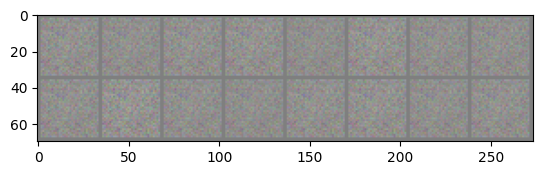

D입장에서 줄여야 하는 G_Avg Loss = 0.522839, G입장에서 줄여야 하는 G_Avg Loss = 2.849868
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


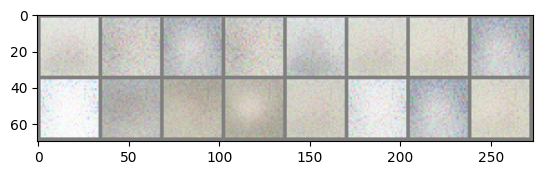

D입장에서 줄여야 하는 G_Avg Loss = 0.838568, G입장에서 줄여야 하는 G_Avg Loss = 1.856257
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


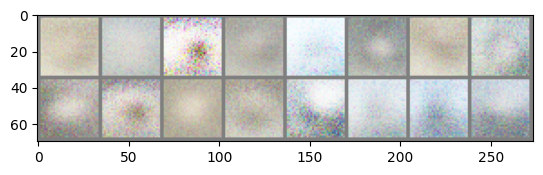

D입장에서 줄여야 하는 G_Avg Loss = 0.922784, G입장에서 줄여야 하는 G_Avg Loss = 1.761680
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


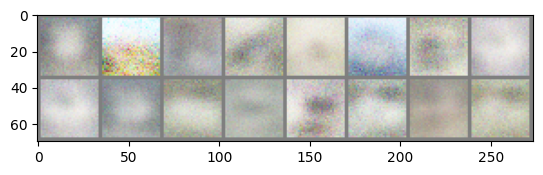

D입장에서 줄여야 하는 G_Avg Loss = 0.849275, G입장에서 줄여야 하는 G_Avg Loss = 2.074203
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


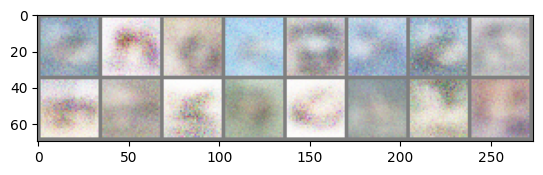

D입장에서 줄여야 하는 G_Avg Loss = 0.759433, G입장에서 줄여야 하는 G_Avg Loss = 2.386703
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


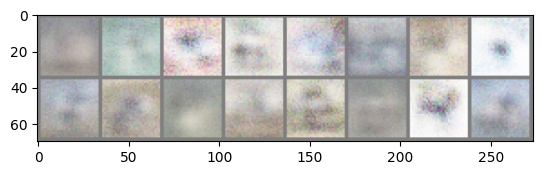

D입장에서 줄여야 하는 G_Avg Loss = 0.832355, G입장에서 줄여야 하는 G_Avg Loss = 2.084402
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


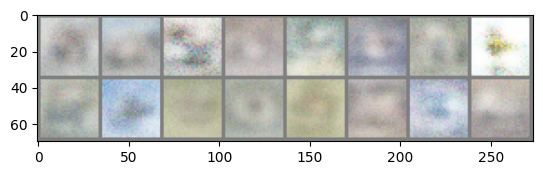

D입장에서 줄여야 하는 G_Avg Loss = 0.780379, G입장에서 줄여야 하는 G_Avg Loss = 2.314963
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


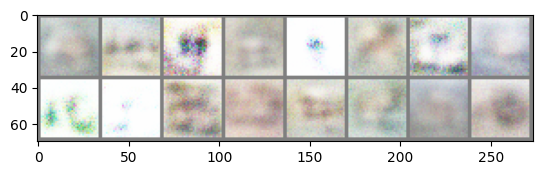

D입장에서 줄여야 하는 G_Avg Loss = 0.730428, G입장에서 줄여야 하는 G_Avg Loss = 2.664395
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


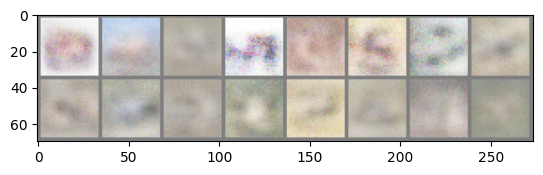

D입장에서 줄여야 하는 G_Avg Loss = 0.738742, G입장에서 줄여야 하는 G_Avg Loss = 2.425738
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


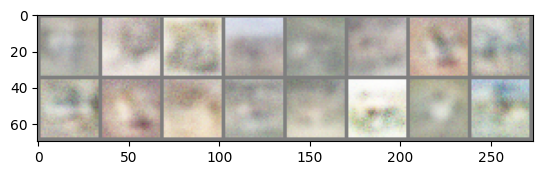

D입장에서 줄여야 하는 G_Avg Loss = 0.685633, G입장에서 줄여야 하는 G_Avg Loss = 2.804568
D_Avg_Loss -> 100, G_Avg_Loss -> 0 가 된다면, 이는 노이즈를 G에 넣어 만들어낸 가짜 이미지를 D가 아예 구분 못 하는 상태
torch.Size([16, 3072])
torch.Size([16, 3, 32, 32])


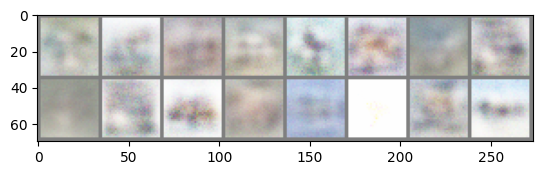

In [16]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/ML/gan"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node":3072,

              "d_hidden_node1":2000,
              "d_hidden_node2":1000,
              "d_hidden_node3":500,
              "d_hidden_node4":200,

              "d_output_node":1,

              "g_input_node":100,

              "g_hidden_node1":2000,
              "g_hidden_node2":1000,
              "g_hidden_node3":500,
              "g_hidden_node4":200,

              "g_output_node":3072,

              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    train(config)

## '검사자의 층보다 생성자의 층을 깊게 만들어줬을 때'보다 '검사자의 층을 생성자의 층보다 깊게 만들어줬을 때'에 오히려 생성자가 검사자를 속이는 경우도 더 많아지는데 그 이유:

* 디스크리미네이터가 너무 복잡해지면 **과적합(overfitting)**이 발생할 수 있습니다. 즉, 디스크리미네이터가 훈련 데이터(진짜 이미지)에 매우 잘 맞춰지기 시작하고, 생성한 가짜 이미지에는 잘 반응하지 않게 됩니다.

* 이 경우, 디스크리미네이터는 "진짜 이미지"에 대해서만 너무 강력하게 반응하고, 새로운 가짜 이미지를 구별하기 어려워질 수 있습니다. 즉, 디스크리미네이터가 새로운 형태의 가짜 이미지를 다루는 데 적응하지 못하고, 학습이 잘못 진행될 수 있습니다.
즉, 가짜 이미지의 복잡한 특성을 학습하기 어려움

* 디스크리미네이터가 너무 깊으면, 가짜 이미지에 대한 평가가 복잡해져서 학습이 불안정해질 수 있습니다. 이때 디스크리미네이터는 가짜 이미지의 아주 작은 세부 사항을 지나치게 강조하고, 그로 인해 일반화가 잘 되지 않게 됩니다.